# Sistema de Detección de Ciberataques DDoS por Análisis de Tráfico de Red
### Máster en Inteligencia Artificial aplicada al sector de la Energía e Infraestructuras

**Autor:** Ramiro Bueno Martínez  
**Fecha:** 05/05/2024  
**Versión:** R200


**Descripción:** Comparativa de Metodos de Apendizaje Profundo DL/AI

<h1> Dataset </h1>
Conjunto de Datos relativo a la documentación de un Ataque de Denegación Distribuida de Servicio (DDoS), realizado a partir del conjunto de datos publicado por el Instituto de Ciber Seguridad Canadiense (CIC) el año 2019.

<h3> Licencia: </h3>

Segun la información proporcionada por el Instituto Canadiense de Ciberseguridad es posible redistribuir,
volver a publicar y reflejar el conjunto de datos CICDDoS2019 en cualquier forma.
https://www.unb.ca/cic/datasets/ddos-2019.html
Sin embargo, cualquier uso o redistribución de los datos debe incluir una cita al conjunto de datos CICDDoS2019 y el artículo publicado relacionado. Un trabajo de investigación en el que se esbozan los detalles de analizar el conjunto de datos IDS/IPS similar y principios relacionados:

- Iman Sharafaldin, Arash Habibi Lashkari, Saqib Hakak y Ali A. Ghorbani, ” Developing Realistic Distributed Denial of Service of Service (DDoS) Attack Dataset and Taxonomy “, IEEE 53rd International Carnahan Conference on Security Technology, Chennai, India, 2019. DOI: 10.1109/CCST.2019.8888419

## Análisis de Tráfico de Red en Ataques DDoS
Un ataque de denegación de servicio distribuido (DDoS) es una amenaza crítica para la seguridad de las redes. Estos ataques intentan saturar la red de destino mediante tráfico malicioso, provocando interrupciones en los servicios legítimos. A pesar del desarrollo de diversos métodos estadísticos, la detección eficaz en tiempo real sigue siendo un reto, especialmente con recursos computacionales limitados.

La evaluación de nuevos enfoques de detección requiere conjuntos de datos bien estructurados, lo cual motiva este estudio.

## Referencias Normativas Estándar
- [ISO/IEC FDIS 23053 - Framework for AI Systems Using ML (en desarrollo)](https://www.iso.org/standard/74438.html)
- [ISO/IEC CD 8183 - Data Life Cycle Framework (en desarrollo)](https://www.iso.org/standard/83002.html)
- [ISO/IEC DIS 24668 - Process Management Framework for Big Data Analytics (en desarrollo)](https://www.iso.org/standard/78368.html)
- [ISO/IEC CD 5338 - AI System Life Cycle Processes (en desarrollo)](https://www.iso.org/standard/81118.html)

## Índice de Contenidos
1. [Objetivo del Proyecto](#objetivo)
2. [Importación de Librerías](#importacion)
3. [Carga y Exploración de Datos](#datos)
4. [Preprocesamiento](#preprocesamiento)
5. [Entrenamiento del Modelo](#modelo)
6. [Evaluación y Resultados](#evaluacion)
7. [Conclusiones y Recomendaciones](#conclusiones)

## Objetivo del Proyecto

Determinar en tiempo real, mediante la monitorización de tramas de datos de tráfico de red con herramientas como `tshark`, si se está produciendo un ataque DDoS (etiqueta `DDoS`) o si el tráfico es normal (etiqueta `BENIGN`).

In [1]:
import concurrent.futures
import csv
import datetime
import ipaddress
import math
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
import pandas as pd
import pickle
import psutil
import random
import seaborn as sns
import sys
import time
import tracemalloc
import warnings
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, 
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, 
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from tabulate import tabulate
import logging
# Configuración de logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

In [2]:
from datetime import datetime

# Lista de características seleccionadas manualmente
selected_features = [
    'Source IP','Destination IP','Source Port','Destination Port','Protocol', 
    'Fwd Packets/s','Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 
    'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 
    'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Bwd Packet Length Max', 
    'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Flow Bytes/s', 'Flow Packets/s', 
    'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count',
    'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 
    'Average Packet Size', 'Init_Win_bytes_forward','Init_Win_bytes_backward', 
    'act_data_pkt_fwd', 'min_seg_size_forward', 'Active Mean', 'Active Std', 'Active Max', 'Active Min',
    'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min','Label'
]

reduced_set_of_features_II = [
    'Timestamp','Source IP','Destination IP','Source Port','Destination Port','Protocol',
    'Fwd Packets/s','Bwd Packets/s','Flow Bytes/s', 'Flow Packets/s',
    'Total Fwd Packets','Total Backward Packets', 'Total Length of Fwd Packets','Total Length of Bwd Packets',
    'Fwd Packet Length Std','Bwd Packet Length Std','Flow Duration',
    'Flow IAT Std','Bwd IAT Mean','Bwd IAT Std','Bwd IAT Min',
    'SYN Flag Count','FIN Flag Count','PSH Flag Count', 'Active Std','Idle Std',
    'Fwd Header Length','Bwd Header Length','Fwd Header Length', 'Label']

PCA_25_Attributes = ['Fwd IAT Std', 'Fwd IAT Mean', 'Fwd IAT Total', 'Flow IAT Min', 'Flow IAT Max', 
                     'Flow IAT Std', 'Flow IAT Mean', 'Flow Packets/s', 'Flow Bytes/s', 
                     'Bwd Packet Length Std', 'Bwd Packet Length Mean', 'Bwd Packet Length Min', 
                     'Bwd Packet Length Max', 'Fwd Packet Length Std', 'Fwd Packet Length Mean', 
                     'Fwd Packet Length Min', 'Fwd Packet Length Max', 'Total Length of Bwd Packets',
                     'Total Length of Fwd Packets', 'Total Backward Packets', 'Total Fwd Packets', 
                     'Flow Duration', 'Protocol', 'Destination Port',
                     'Source Port','Label']  #'Inbound'

# Lista de Atributos mas significativos para elaborar mi propio conjunto de datos
Training_Attributes = ['Timestamp','Source IP','Destination IP','Protocol', 'Destination Port', 
                       'Source Port', 'Flow Duration','Flow Packets/s', 'Flow Bytes/s', 'Fwd IAT Std', 
                       'Fwd IAT Mean', 'Fwd IAT Total', 'Flow IAT Min', 'Flow IAT Max', 'Flow IAT Std',
                       'Flow IAT Mean', 'Bwd Packet Length Std', 'Bwd Packet Length Mean', 
                       'Bwd Packet Length Min', 'Bwd Packet Length Max', 'SYN Flag Count', 
                       'FIN Flag Count','PSH Flag Count','ACK Flag Count', 'Fwd Packet Length Std', 
                       'Fwd Packet Length Mean', 'Fwd Packet Length Min', 'Fwd Packet Length Max', 
                       'Total Length of Bwd Packets', 'Total Length of Fwd Packets', 
                       'Total Backward Packets', 'Total Fwd Packets','Label'] #'Inbound'

Main_Attributes = ['Timestamp','Source IP','Destination IP','Protocol', 'Destination Port', 'Source Port', 
                   'Flow Duration','Flow Packets/s', 'Flow Bytes/s', 'Fwd IAT Std', 'Fwd IAT Mean', 
                   'Fwd IAT Total', 'Flow IAT Min', 'Flow IAT Max', 'Flow IAT Std','Flow IAT Mean',
                   'Bwd Packet Length Std', 'Bwd Packet Length Mean', 'Bwd Packet Length Min', 
                   'Bwd Packet Length Max', 'SYN Flag Count', 'FIN Flag Count','PSH Flag Count',
                   'ACK Flag Count', 'Fwd Packet Length Std', 'Fwd Packet Length Mean', 'Fwd Packet Length Min', 
                   'Fwd Packet Length Max', 'Total Length of Bwd Packets', 'Total Length of Fwd Packets',
                   'Total Backward Packets', 'Total Fwd Packets','Label']

# Define the global variable PCA_8_Attributes
PCA_8_Attributes = [
    'Fwd Packet Length Mean', 'Fwd Packet Length Min', 'Fwd Packet Length Max',
    'Total Length of Bwd Packets', 'Total Length of Fwd Packets',
    'Total Backward Packets', 'Total Fwd Packets', 'Flow Duration'
]


top_50_features = selected_features
top_25_features = reduced_set_of_features_II
extended_set_of_features = ['Timestamp','Source IP','Destination IP','Source Port', 'Destination Port','Protocol']

fecha_formateada = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"{fecha_formateada} - FASE I.- [Exploracion Conjunto de Datos] - Atributos del Conjunto de Datos CIC-DDoS2019")

2025-08-11 19:51:32 - FASE I.- [Exploracion Conjunto de Datos] - Atributos del Conjunto de Datos CIC-DDoS2019


In [3]:
from datetime import datetime

file_production_paths = [
    'C:/DataSets/Produccion/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv'
]

output_file_reflection_tcp = 'C:/DataSets/Training/Training_Exp_Attack_TCP.csv'
output_file_reflection_udp ='C:/DataSets/Training/Training_Exp_Attack_UDP.csv'
output_file_reflection_mixed ='C:/DataSets/Training/Training_Ref_Attack_MIXED.csv'
output_file_exploitation_tcp = 'C:/DataSets/Training/Training_Ref_Attack_TCP.csv'
output_file_exploitation_udp = 'C:/DataSets/Training/Training_Ref_Attack_UDP.csv'

fecha_formateada = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"{fecha_formateada} - FASE I.- [Exploracion Conjunto de Datos] - Conjuntos de Datos por Exploar de CIC-DDoS2019")

2025-08-11 19:51:32 - FASE I.- [Exploracion Conjunto de Datos] - Conjuntos de Datos por Exploar de CIC-DDoS2019


In [4]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from datetime import datetime, timedelta
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches

# Ignorar las advertencias de pandas para mantener la salida limpia.
warnings.filterwarnings("ignore")

# --- Funciones de Cálculo de Métricas de Calidad del Modelo de Datos ---

def f_metricas_calidad_modelo_datos(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calcula un conjunto de métricas de calidad para un DataFrame de datos de red.

    Esta función actúa como un orquestador, llamando a cada métrica individual y
    compilando los resultados en un DataFrame para una fácil visualización.

    Args:
        df (pd.DataFrame): El DataFrame de entrada que contiene los datos a evaluar.

    Returns:
        pd.DataFrame: Un DataFrame con las métricas de calidad y sus valores.
    """
    print("\n[Benchmarking] Calidad del Modelo de Datos")

    # Se pasa el DataFrame directamente a cada métrica para evitar variables globales.
    metricas = {
        'Exactitud': exactitud_metric(df),
        'Completitud': completitud_metric(df),
        'Consistencia': consistencia_metric(df),
        'Credibilidad': credibilidad_metric(df),
        'Actualidad': actualidad_metric(df),
        'Balanceado': balanceado_metric(df)
    }

    # Convertir las métricas a un DataFrame para una presentación clara.
    df_metricas = pd.DataFrame.from_dict(metricas, orient='index', columns=['Valor'])

    return df_metricas


def exactitud_metric(df: pd.DataFrame) -> float:
    """
    Calcula la exactitud como el porcentaje de filas sin valores nulos en el DataFrame.
    Un valor del 100% indica que todas las filas están completas.

    Args:
        df (pd.DataFrame): DataFrame a evaluar.

    Returns:
        float: El porcentaje de filas completas.
    """
    print("[Benchmarking] Exactitud del modelo")
    num_exactos = df.dropna().shape[0]
    num_total = len(df)
    print(f"Exactitud: Exactos {num_exactos} Totales {num_total}")
    return (num_exactos / num_total) * 100 if num_total > 0 else 0


def completitud_metric(df: pd.DataFrame) -> float:
    """
    Calcula la completitud como el porcentaje de filas sin valores nulos.
    Esta métrica es funcionalmente similar a la exactitud en este contexto,
    evaluando si todos los campos de una fila están presentes.

    Args:
        df (pd.DataFrame): DataFrame a evaluar.

    Returns:
        float: El porcentaje de filas completas.
    """
    print("[Benchmarking] Completitud del modelo")
    num_completos = df.dropna().shape[0]
    num_total = len(df)
    print(f"Completitud: Completos {num_completos} Totales {num_total}")
    return (num_completos / num_total) * 100 if num_total > 0 else 0


def consistencia_metric(df: pd.DataFrame) -> float:
    """
    Calcula la consistencia asegurando que la IP de origen y la de destino
    no sean idénticas en la misma fila, lo que indicaría un bucle de tráfico
    inconsistente en los datos.

    Args:
        df (pd.DataFrame): DataFrame a evaluar (debe contener 'Source IP' y 'Destination IP').

    Returns:
        float: El porcentaje de filas con IPs de origen y destino diferentes.
    """
    print("[Benchmarking] Consistencia del modelo")
    # Se filtran las filas donde la IP de origen es diferente de la de destino.
    num_consistentes = (df['Source IP'] != df['Destination IP']).sum()
    num_total = len(df)
    print(f"Consistencia: Consistentes {num_consistentes} Totales {num_total}")
    return (num_consistentes / num_total) * 100 if num_total > 0 else 0


def credibilidad_metric(df: pd.DataFrame) -> float:
    """
    Calcula la credibilidad verificando el formato de las IPs de origen y destino
    y la validez del campo 'Timestamp'.

    Args:
        df (pd.DataFrame): DataFrame a evaluar.

    Returns:
        float: Porcentaje de filas que cumplen con los criterios de credibilidad.
    """
    print("[Benchmarking] Credibilidad del modelo")

    # Convertir 'Timestamp' a formato de fecha y hora, los errores se convierten en NaT.
    df_temp = df.copy()
    df_temp['Timestamp'] = pd.to_datetime(df_temp['Timestamp'], errors='coerce')

    # Evaluar si las IPs tienen un formato básico de 4 octetos separados por puntos
    # y si el 'Timestamp' es un valor de fecha y hora válido.
    is_valid_ip_src = df_temp['Source IP'].str.count('.') == 3
    is_valid_ip_dst = df_temp['Destination IP'].str.count('.') == 3
    is_valid_timestamp = df_temp['Timestamp'].notna()

    num_veraces = (is_valid_ip_src & is_valid_ip_dst & is_valid_timestamp).sum()
    num_total = len(df)

    print(f"Credibilidad: Veraces {num_veraces} Totales {num_total}")
    return (num_veraces / num_total) * 100 if num_total > 0 else 0


def actualidad_metric(df: pd.DataFrame, current_year: int = 2024, data_year: int = 2019) -> float:
    """
    Calcula una métrica de actualidad basada en una diferencia de años.
    Esta es una métrica heurística que penaliza los datos más antiguos.

    Args:
        df (pd.DataFrame): DataFrame a evaluar.
        current_year (int): El año actual para el cálculo.
        data_year (int): El año de referencia de los datos.

    Returns:
        float: Un valor de actualidad ajustado.
    """
    print("[Benchmarking] Actualidad del modelo")
    num_total = len(df)

    # Calcular el factor de penalización por antigüedad.
    # Por ejemplo, si la diferencia es de 5 años, el factor es (1 - 5/100) = 0.95.
    factor = 1 - (current_year - data_year) / 100

    # Se considera que todas las filas contribuyen a la actualidad
    # de manera ponderada por el factor de antigüedad.
    actualidad = (100 * factor) if num_total > 0 else 0

    print(f"Actualidad: Año de los datos {data_year}, Año actual {current_year}")
    return actualidad


def balanceado_metric(df: pd.DataFrame) -> float:
    """
    Calcula la métrica de balance de clases. Retorna el porcentaje de la
    clase más frecuente ('BENIGN' en este caso). Un valor más cercano a
    un balance ideal (por ejemplo, 50% en un problema binario) es mejor.

    Args:
        df (pd.DataFrame): DataFrame a evaluar (debe contener la columna 'Label').

    Returns:
        float: Porcentaje de la clase 'BENIGN' en el dataset.
    """
    print("[Benchmarking] Balanceado del modelo")

    # Imprimir el porcentaje de cada clase para un análisis detallado.
    print("Distribución de etiquetas:")
    total_samples = len(df)
    if total_samples > 0:
        for classificador, count in df['Label'].value_counts().items():
            print(f"  - Etiqueta '{classificador}': {round(count / total_samples * 100, 2)}% del dataset")

        # Se retorna el porcentaje de la clase 'BENIGN' como métrica de balance.
        benign_percentage = df['Label'].value_counts(normalize=True).get('BENIGN', 0) * 100
    else:
        benign_percentage = 0

    return benign_percentage


# --- Funciones de Visualización ---

def radar_plot_with_table(metricas_df1: pd.DataFrame, metricas_df2: pd.DataFrame, df1_name: str, df2_name: str):
    """
    Genera un gráfico de radar y una tabla comparativa para dos conjuntos de métricas.

    Args:
        metricas_df1 (pd.DataFrame): DataFrame con las métricas del primer conjunto de datos.
        metricas_df2 (pd.DataFrame): DataFrame con las métricas del segundo conjunto de datos.
        df1_name (str): Nombre del primer conjunto de datos.
        df2_name (str): Nombre del segundo conjunto de datos.
    """
    print("Graficando diagramas de radar ....")
    labels = metricas_df1.index
    num_vars = len(labels)

    # Convertir las métricas en listas para el gráfico.
    values1 = [float(x) for x in metricas_df1['Valor'].tolist()]
    values2 = [float(x) for x in metricas_df2['Valor'].tolist()]

    # Añadir el primer valor al final para cerrar el gráfico.
    values1 += values1[:1]
    values2 += values2[:1]

    # Calcular los ángulos de cada eje para el gráfico de radar.
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    # Crear los subplots para el gráfico de radar y la tabla.
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

    # --- Gráfico de Radar ---
    ax1 = plt.subplot(121, polar=True)
    ax1.fill(angles, values1, color='red', alpha=0.25, label=df1_name)
    ax1.fill(angles, values2, color='blue', alpha=0.25, label=df2_name)
    ax1.plot(angles, values1, color='red', linewidth=2)
    ax1.plot(angles, values2, color='blue', linewidth=2)

    ax1.set_title('Métricas de Calidad del Modelo de Datos', size=16, color='black', y=1.1)
    ax1.set_yticklabels([])
    ax1.set_xticks(angles[:-1])
    ax1.set_xticklabels(labels, fontsize=12)
    ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    # --- Tabla Comparativa ---
    table_data = {
        'KPI': labels,
        df1_name: [f'{v:.1f}%' for v in values1[:-1]],
        df2_name: [f'{v:.1f}%' for v in values2[:-1]]
    }
    df_table = pd.DataFrame(table_data)

    ax2.set_title(f'Comparativa de la Calidad del Modelo de Datos', size=16)
    ax2.axis('off')
    table = ax2.table(cellText=df_table.values, colLabels=df_table.columns, cellLoc='center', loc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.auto_set_column_width(col=list(range(len(df_table.columns))))
    table.scale(1, 1.8)

    plt.tight_layout()
    plt.show()



# Llamada a la función para crear el gráfico de radar y la tabla
#radar_plot_with_table(metricas_df1, metricas_df2, df1_name='CICDDoS2019', df2_name='ASSG-DDoS2024')

In [5]:
def f_process_read_csv(file_path):

    print("1.1- [Data Collection] Process-CSV: [{}]\n".format(file_path))

    factor_sampling = 1 # 1-100
    try:
        filtered_df = pd.read_csv(file_path, low_memory=False, delimiter=',', quotechar='"')
        start_time = time.time()
        filtered_df = filtered_df.rename(columns=lambda x: x.strip())
        end_time = time.time()
        execution_time = end_time - start_time
        print("1.2.- [Data Collection] Finalización carga de Tiempo: {:.2f} secs\n [{}]"
              .format(execution_time,file_path))

        filtered_df = filtered_df.iloc[::factor_sampling]  # Realizar un submuestreo 1 de cada 3 muestras

        print("1.4.- [Data Collection] Finalizada la carga del conjunto de datos: [{}]\n"
              .format(file_path))
        print('1.5.- [Data Collection] - Clasificador: ', filtered_df['Label'].unique())
        for classificador in filtered_df['Label'].unique():
            print('Etiqueta: ', classificador, round(filtered_df['Label']
                                                     .value_counts()[classificador]/len(filtered_df) * 100,2), '% del dataset')
        return filtered_df

    except Exception as ex:
        print("1.1.- [Data Collection] Excepcion: ", ex)
        return None

In [6]:
import pandas as pd
import numpy as np
import ipaddress
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from typing import NoReturn

def _normalize_ip_address(ip: str) -> str:
    """
    Intenta normalizar una dirección IP. Si no es válida, la devuelve sin cambios.
    """
    try:
        # Se asegura de que la IP sea una cadena válida antes de procesarla.
        if isinstance(ip, str):
            return str(ipaddress.ip_address(ip))
        return str(ip)
    except ValueError:
        return ip
    except Exception:
        # En caso de otro error, devuelve la IP original para no detener el proceso.
        return ip

def f_cleaning(data: pd.DataFrame) -> pd.DataFrame:
    """
    Realiza un proceso de limpieza completo en un DataFrame.

    El proceso incluye la eliminación de duplicados, el manejo de valores
    infinitos y nulos, el etiquetado de la columna 'Label', la conversión
    de tipos de datos, la normalización de direcciones IP y la eliminación
    de columnas innecesarias.

    Args:
        data (pd.DataFrame): El DataFrame de entrada para limpiar.

    Returns:
        pd.DataFrame: El DataFrame limpio y procesado.

    Raises:
        Exception: Propaga cualquier excepción que ocurra durante la ejecución.
    """
    print("--- 2.1 [Data Cleaning] Iniciando proceso de limpieza de datos. ---")

    try:
        # Paso 1: Eliminar filas duplicadas
        initial_rows = len(data)
        data = data.drop_duplicates()
        removed_duplicates = initial_rows - len(data)
        print(f"-> 2.1.1 Eliminación de filas duplicadas. Filas eliminadas: {removed_duplicates}")

        # Paso 2: Manejo de valores infinitos y nulos
        print("-> 2.1.2 Manejando valores nulos, infinitos y tipos de datos.")

        # Reemplazar valores infinitos por NaN para una imputación posterior
        data.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Identificar columnas numéricas y categóricas
        numeric_columns = data.select_dtypes(include=np.number).columns
        categorical_columns = data.select_dtypes(include='object').columns

        # Imputar valores nulos en campos numéricos (estrategia: mediana)
        num_imputer = SimpleImputer(strategy='median')
        data[numeric_columns] = num_imputer.fit_transform(data[numeric_columns])

        # Imputar valores nulos en campos categóricos (estrategia: moda)
        cat_imputer = SimpleImputer(strategy='most_frequent')
        data[categorical_columns] = cat_imputer.fit_transform(data[categorical_columns])


        # Paso 3: Proceso de Labeling
        if 'Label' in data.columns:
            print("-> 2.1.3 Procesando la columna 'Label'.")

            # Unificar etiquetas: todo lo que no sea 'BENIGN' se etiqueta como 'DDoS'
            data['Label'] = data['Label'].apply(lambda x: 'DDoS' if x != 'BENIGN' else x)

            # Presentar la distribución de las etiquetas
            print("-> Presentación de resultados: Distribución de Etiquetas")
            label_counts = data['Label'].value_counts(normalize=True) * 100
            for classificador, porcentaje in label_counts.items():
                print(f"    - Etiqueta: '{classificador}', Porcentaje: {porcentaje:.2f}% del dataset")
        else:
            print("-> Advertencia: La columna 'Label' no existe. Se omite el etiquetado.")


        # Paso 4: Conversión de campos y normalización de IPs
        print("-> 2.1.4 Conversión de campos y normalización de IPs.")

        # Convertir 'Timestamp' a formato de fecha y hora, si existe
        if 'Timestamp' in data.columns:
            data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')
        else:
            print("-> Advertencia: La columna 'Timestamp' no existe. Se omite la conversión.")

        # Normalizar direcciones IP
        ip_columns = [col for col in ['Source IP', 'Destination IP'] if col in data.columns]
        if ip_columns:
            for col in ip_columns:
                data[col] = data[col].astype(str).apply(_normalize_ip_address)
            print("-> IPs corruptas recuperadas y normalizadas.")
        else:
            print("-> Advertencia: Las columnas de IP no existen. Se omite la normalización.")


        # Paso 5: Eliminar columnas innecesarias
        columns_to_drop = [col for col in ['Unnamed: 0', 'Inbound'] if col in data.columns]
        if columns_to_drop:
            data = data.drop(columns=columns_to_drop)
            print(f"-> 2.1.5 Columnas eliminadas: {columns_to_drop}")

        print("--- 2.1 [Data Cleaning] Proceso de limpieza finalizado. ---")
        return data

    except Exception as ex:
        print(f"[Data Cleaning] Excepción: {ex}")
        raise # Propagar la excepción

In [7]:
def explore_datasets_in_directory(directory_path: str, attributes: list):
    """
    Recorre un directorio, explora cada dataset CSV y genera un informe.
    """
    if not os.path.isdir(directory_path):
        print(f"Error: El directorio '{directory_path}' no existe.")
        return

    print("=========================================================================")
    print("FASE I.- [Exploración de Conjuntos de Datos] - Inicio")
    print("=========================================================================")

    # Obtener la lista de archivos en el directorio
    files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]

    if not files:
        print(f"No se encontraron archivos CSV en el directorio: {directory_path}")
        return

    for file_name in files:
        input_file = os.path.join(directory_path, file_name)
        print(f"\n--- Procesando archivo: {file_name} ---")

        try:
            # 1. Carga inicial del dataset
            df = f_process_read_csv(input_file)
            if df is None:
                continue

            initial_rows, initial_cols = df.shape
            print(f"Filas iniciales: {initial_rows}, Columnas iniciales: {initial_cols}")

            #print("Exploracion del Conjunto de Datos sin Procesar: ")
            #for column, dtype in df.dtypes.items():
              #print(f"Columna: {column}, Tipo: {dtype}")

            # 2. Limpieza de datos
            df = f_cleaning(df)

            final_rows, final_cols = df.shape
            print(f"Filas Intermedias: {final_rows}, Columnas Intermedias: {final_cols}")

            # 3. Selección de atributos
            if not all(attr in df.columns for attr in attributes):
                missing_attrs = [attr for attr in attributes if attr not in df.columns]
                print(f"Advertencia: Faltan los siguientes atributos: {missing_attrs}")
                df = df.loc[:, df.columns.intersection(attributes)]
            else:
                df = df[attributes]

            # 4. Preprocesamiento final
            df = f_preprocesado(df)
            final_rows, final_cols = df.shape

            final_rows, final_cols = df.shape
            print(f"Filas Procesadas: {final_rows}, Columnas Procesadas: {final_cols}")

            # 5. Generar y mostrar el informe de exploración
            report = [
                ["Métrica", "Valor"],
                ["Nombre del Archivo", file_name],
                ["Filas Iniciales", initial_rows],
                ["Columnas Iniciales", initial_cols],
                ["Filas Finales", final_rows],
                ["Columnas Finales", final_cols],
                ["Total de Filas Eliminadas", initial_rows - final_rows],
                ["Total de Columnas Eliminadas", initial_cols - final_cols]
            ]

            final_rows, final_cols = df.shape
            print(f"Filas Finales: {final_rows}, Columnas Finales: {final_cols}")


            print("\n--- Informe de Exploración ---")
            print(tabulate(report, headers="firstrow", tablefmt="fancy_grid"))

        except Exception as e:
            print(f"Error inesperado al procesar '{file_name}': {e}")

    print("\n=========================================================================")
    print("FASE I.- [Exploración de Conjuntos de Datos] - Fin")
    print("=========================================================================")

# Ruta del directorio con los datasets de entrenamiento
#data_directory = 'C:/DataSets/Training/'
# Ejecutar la exploración
#explore_datasets_in_directory(data_directory, PCA_25_Attributes)


In [8]:
import pandas as pd
import numpy as np
import warnings

def f_preprocesado(data: pd.DataFrame) -> pd.DataFrame:
    """
    Realiza un preprocesado de datos verificando la presencia de valores nulos
    e infinitos, y muestra los tipos de datos de las columnas.

    Esta función es una fase de verificación para asegurar que el DataFrame
    esté listo para el modelado.

    Args:
        data (pd.DataFrame): El DataFrame de entrada para preprocesar.

    Returns:
        pd.DataFrame: El DataFrame procesado.
    """
    print("3.1.- [Preprocesado] Iniciando el preprocesado de datos.")

    try:
        # --- 3.1.1 Verificación de valores nulos ---
        nan_values_count = data.isnull().sum().sum()
        if nan_values_count > 0:
            print(f"3.1.1.- [Preprocesado] El DataFrame tiene {nan_values_count} nulos.")
            # Opcional: Podrías añadir una estrategia para manejar estos nulos, por ejemplo:
            # data = data.fillna(0)
        else:
            print("3.1.1.- [Preprocesado] Verificado: No hay valores nulos en el DataFrame.")

        # --- 3.1.2 Verificación de valores infinitos (CORREGIDO) ---
        # Se filtran las columnas para trabajar solo con datos numéricos.
        numeric_data = data.select_dtypes(include=[np.number])

        # Se ignora el warning de `isinf` si no hay columnas numéricas.
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            inf_values_count = np.isinf(numeric_data).sum().sum()

        if inf_values_count > 0:
            print(f"3.1.2.- [Preprocesado] El DataFrame contiene {inf_values_count} valores infinitos.")
            # Opcional: Podrías añadir una estrategia para manejar estos infinitos, por ejemplo:
            # data.replace([np.inf, -np.inf], np.nan, inplace=True)
        else:
            print("3.1.2.- [Preprocesado] Verificado: No hay valores infinitos en el DataFrame.")

        # --- 3.1.3 Muestra de atributos del conjunto de datos ---
        print("\n3.1.3.- [Preprocesado] ATRIBUTOS DEL CONJUNTO DE DATOS PROCESADO:")
        data.info() # Usar data.info() es una forma más estándar y completa de mostrar esta información.

        print("\n3.2.- [Preprocesado] ¡Preprocesado finalizado!")
        return data

    except Exception as ex:
        print(f"\n[Preprocesado] Excepción: {ex}")
        raise

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import warnings
from typing import Tuple, Dict, List


def f_balancear_dataset_oversampling(
    df: pd.DataFrame,
    # Se utiliza un diccionario para mayor flexibilidad en los ratios de cualquier número de clases
    ratios: Dict[str, float],
    target_samples: int = 30000,
    random_state: int = 42
) -> pd.DataFrame:
    """
    Balancea un conjunto de datos desequilibrado con SMOTE para oversampling
    y luego submuestrea para alcanzar un tamaño objetivo con proporciones
    de clases específicas.

    Args:
        df (pd.DataFrame): El DataFrame de entrada. Debe contener una columna 'Label'.
        ratios (Dict[str, float]): Un diccionario con las proporciones deseadas para cada clase.
                                   Ejemplo: {'BENIGN': 0.5, 'DDoS': 0.5}.
                                   La suma de los valores debe ser 1.0.
        target_samples (int): El número total de muestras en el dataset final.
        random_state (int): Semilla para la reproducibilidad de los resultados.

    Returns:
        pd.DataFrame: Un nuevo DataFrame balanceado con los datos sintéticos filtrados.
    
    Raises:
        ValueError: Si las validaciones iniciales fallan (columnas faltantes o ratios incorrectos).
    """
    logger.info("--- [Balanceo] Iniciando el proceso de balanceo del conjunto de datos ---")

    # 1. Validación inicial de entrada
    if 'Label' not in df.columns:
        raise ValueError("Error: El DataFrame de entrada no contiene la columna 'Label'.")
    
    # Se valida que la suma de los ratios sea 1.0
    if not np.isclose(sum(ratios.values()), 1.0):
        raise ValueError("Error: La suma de los valores en el diccionario 'ratios' debe ser 1.0.")

    try:
        initial_rows, initial_cols = df.shape
        logger.info(f"Dimensiones iniciales del DataFrame: {initial_rows} x {initial_cols}")

        # 2. Separación de características y etiquetas
        X = df.drop('Label', axis=1)
        y = df['Label']

        # 3. Mostrar balance inicial y preparar codificador
        logger.info("\n[Balanceo] Balance inicial del conjunto de datos:")
        label_counts = y.value_counts(normalize=True) * 100
        for label, percentage in label_counts.items():
            print(f"  - Etiqueta '{label}': {percentage:.2f}%")
        
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)
        
        # 4. Aplicación de SMOTE (se usa la estrategia 'auto' para oversamplear todas las minoritarias)
        logger.info("\n[Balanceo] Aplicando oversampling con SMOTE para igualar las clases.")
        smote_sampler = SMOTE(sampling_strategy='auto', random_state=random_state)
        X_resampled, y_resampled_encoded = smote_sampler.fit_resample(X, y_encoded)
        
        df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
        df_resampled['Label'] = le.inverse_transform(y_resampled_encoded)
        logger.info(f"Oversampling con SMOTE finalizado. Nuevas dimensiones: {len(df_resampled)} x {len(df_resampled.columns)}")
        
        # 5. Filtrado de datos atípicos sintéticos
        logger.info("\n[Balanceo] Filtrando datos atípicos sintéticos.")
        outlier_threshold = 3.0
        
        numeric_features = df_resampled.select_dtypes(include=['float64', 'int64']).columns.drop('Label', errors='ignore')
        
        # Se calcula la media y la desviación estándar solo de los datos originales para evitar sesgos
        original_stats = df.drop('Label', axis=1).describe()

        for feature in numeric_features:
            if feature in original_stats.columns:
                mean = original_stats.loc['mean', feature]
                std = original_stats.loc['std', feature]
                lower_bound = mean - (std * outlier_threshold)
                upper_bound = mean + (std * outlier_threshold)
                
                df_resampled = df_resampled.loc[
                    (df_resampled[feature] >= lower_bound) & (df_resampled[feature] <= upper_bound)
                ]
            else:
                logger.info(f"  - Advertencia: La característica '{feature}' no se encontró en el DataFrame original.")
        
        # 6. Remuestreo final para alcanzar el tamaño objetivo
        logger.info(f"\n[Balanceo] Remuestreando para un tamaño final de {target_samples} muestras.")
        
        dfs_to_concat = []
        for label, ratio in ratios.items():
            data = df_resampled[df_resampled['Label'] == label]
            num_samples = int(target_samples * ratio)
            
            # Se usa `min` para no solicitar más muestras de las que existen tras el filtrado
            num_samples = min(num_samples, len(data))
            
            # Realizar el muestreo aleatorio
            sampled_data = data.sample(n=num_samples, replace=(len(data) < num_samples), random_state=random_state)
            dfs_to_concat.append(sampled_data)
        
        # Concatenar y mezclar el conjunto de datos final
        df_balanced = pd.concat(dfs_to_concat).sample(frac=1, random_state=random_state).reset_index(drop=True)
        
        # 7. Mostrar el balance final
        logger.info("\n[Balanceo] Balance final del conjunto de datos:")
        label_counts_final = df_balanced['Label'].value_counts(normalize=True) * 100
        for label, percentage in label_counts_final.items():
            print(f"  - Etiqueta '{label}': {percentage:.2f}%")

        final_rows, final_cols = df_balanced.shape
        logger.info(f"Proceso finalizado. Dimensiones del DataFrame de salida: {final_rows} x {final_cols}")

        return df_balanced

    except Exception as ex:
        logger.info(f"\n[Balanceo] ❌ Excepción: {ex}")
        raise

# --- Ejemplo de uso ---
'''
if __name__ == '__main__':
    
    
    input_file = "C:/Datasets/asddos2024/Training/Training_Exp_Attack_TCP.csv"
    df = f_process_read_csv(input_file)
    df = f_cleaning(df)  
    df = f_preprocesado(df)
    logger.info("--- DataFrame Original ---")
    print(df['Label'].value_counts())
    print("-" * 30)
    # Definir los ratios deseados para el balanceo
    ratios_deseados = {'BENIGN': 0.7, 'DDoS': 0.3}
    
    
    # Llamar a la función mejorada de balanceo
    try:
        df_balanceado = f_balancear_dataset_oversampling(
            df=df[PCA_25_Attributes],
            ratios=ratios_deseados,
            target_samples=500000
        )
        logger.info("\n--- DataFrame Balanceado ---")
        print(df_balanceado['Label'].value_counts())
    except ValueError as e:
        logger.info(e)
'''

'\nif __name__ == \'__main__\':\n    \n    \n    input_file = "C:/Datasets/asddos2024/Training/Training_Exp_Attack_TCP.csv"\n    df = f_process_read_csv(input_file)\n    df = f_cleaning(df)  \n    df = f_preprocesado(df)\n    logger.info("--- DataFrame Original ---")\n    print(df[\'Label\'].value_counts())\n    print("-" * 30)\n    # Definir los ratios deseados para el balanceo\n    ratios_deseados = {\'BENIGN\': 0.7, \'DDoS\': 0.3}\n    \n    \n    # Llamar a la función mejorada de balanceo\n    try:\n        df_balanceado = f_balancear_dataset_oversampling(\n            df=df[PCA_25_Attributes],\n            ratios=ratios_deseados,\n            target_samples=500000\n        )\n        logger.info("\n--- DataFrame Balanceado ---")\n        print(df_balanceado[\'Label\'].value_counts())\n    except ValueError as e:\n        logger.info(e)\n'

In [10]:
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, 
from tensorflow.keras.layers import Flatten, LSTM, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import os
import joblib
import pickle
from typing import Tuple, Any, List, Dict

# ==============================================================================
# 1. Definición de las Arquitecturas de los Modelos Optimizados
# ==============================================================================

def create_cnn_model(input_shape: Tuple[int, int], num_classes: int = 2) -> Sequential:
    """
    Crea y compila un modelo de Red Neuronal Convolucional (CNN) 1D optimizado.
    
    Se han añadido capas adicionales, Batch Normalization y Dropout para mejorar
    el rendimiento y la convergencia.
    
    Args:
        input_shape (Tuple[int, int]): La forma de los datos de entrada 
        (longitud de la secuencia, número de características).
        num_classes (int): El número de clases para la capa de salida.
        
    Returns:
        Sequential: El modelo CNN 1D compilado.
    """
    model = Sequential(name="Optimized_CNN")
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def create_lstm_model(input_shape: Tuple[int, int], num_classes: int = 2) -> Sequential:
    """
    Crea y compila un modelo de Red Neuronal Recurrente (LSTM) optimizado.
    
    Se han apilado capas LSTM y se ha añadido Dropout para mejorar la capacidad
    de la red para aprender dependencias temporales y prevenir el sobreajuste.
    
    Args:
        input_shape (Tuple[int, int]): La forma de los datos de entrada (longitud de la secuencia, 
        número de características).
        num_classes (int): El número de clases para la capa de salida.
        
    Returns:
        Sequential: El modelo LSTM compilado.
    """
    model = Sequential(name="Optimized_LSTM")
    
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape, dropout=0.2, recurrent_dropout=0.2))
    
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    
    model.add(Dense(50, activation='relu'))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def create_transfer_learning_model(input_shape: Tuple[int, int], num_classes: int = 2) -> Sequential:
    """
    Crea un modelo de Deep Learning más profundo con múltiples bloques convolucionales,
    inspirado en el concepto de Transfer Learning para datos tabulares.
    
    Este modelo utiliza una arquitectura más compleja para una mejor extracción de
    características jerárquicas del dataset.
    
    Args:
        input_shape (Tuple[int, int]): La forma de los datos de entrada.
        num_classes (int): El número de clases para la capa de salida.
        
    Returns:
        Sequential: El modelo compilado.
    """
    model = Sequential(name="Transfer_Learning_Inspired_CNN")
    
    # Bloque 1
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=input_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    
    # Bloque 2
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    
    # Bloque 3 (extracción de características)
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    
    # Capas densas para clasificación
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def export_keras_model(model: Any, model_name: str, dataset_name: str):
    """
    Exporta un modelo de Keras en el formato nativo de H5.
    
    Args:
        model (Any): El modelo de Keras/TensorFlow a exportar.
        model_name (str): El nombre del modelo.
        dataset_name (str): El nombre del dataset de entrenamiento.
    """
    os.makedirs('models', exist_ok=True)
    sanitized_model_name = model_name.replace(" ", "_").lower()
    sanitized_dataset_name = dataset_name.replace(" ", "_").lower()
    
    filepath = f'models/{sanitized_model_name}_{sanitized_dataset_name}.h5'
    try:
        model.save(filepath)
        print(f"  ✓ Modelo de Keras exportado: {filepath}")
    except Exception as e:
        print(f"  ✗ Error al exportar el modelo de Keras: {e}")

def evaluate_model(model: Any, x_test: pd.DataFrame, y_test: pd.DataFrame):
    """
    Evalua un modelo de Keras 
    
    Args:
        model (Any): El modelo de Keras/TensorFlow a evaluar.
        
    """
    print("[Ingenieria del Modelo] Evaluación del modelo de Keras/TensorFlow")
    #results = model.evaluate(validation_generator)
    results = model.evaluate(x_test, y_test, batch_size=64)
    accuracy = results[1] * 100  # Multiplica por 100 para obtener el porcentaje
    loss = results[0]  # La pérdida se encuentra en la primera posición de los resultados

    print("Accuracy: {:.2f}%".format(accuracy))
    print("Loss: {:.4f}".format(loss))

def plot_results_training(history: Any):
    """
    Visualiza gráficas históricas y convergencia del algoritmo a través de las distintas 
    épocas de entrenamiento.
    
    Args:
        history (Any): Objeto history de Keras con un registro de las pérdidas 
        y métricas de exactitud.
    """
    print("[Ingeniería del Modelo] Evaluación gráfica de convergencia")
    try:
        # Obtener la precisión y la pérdida durante el entrenamiento y la validación
        train_accuracy = history.history['accuracy']
        val_accuracy = history.history['val_accuracy']
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs = range(1, len(train_accuracy) + 1)

        # Gráfico para la precisión
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_accuracy, 'b-o', label='Precisión de entrenamiento')
        plt.plot(epochs, val_accuracy, 'r-o', label='Precisión de validación')
        plt.title('Precisión de entrenamiento y validación')
        plt.xlabel('Épocas')
        plt.ylabel('Precisión')
        plt.legend()
        plt.ylim(0, 1)
        plt.grid(True)

        # Gráfico para la pérdida
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_loss, 'b-o', label='Pérdida de entrenamiento')
        plt.plot(epochs, val_loss, 'r-o', label='Pérdida de validación')
        plt.title('Pérdida de entrenamiento y validación')
        plt.xlabel('Épocas')
        plt.ylabel('Pérdida')
        plt.legend()
        plt.grid(True)

        plt.show()

    except KeyError as ke:
        print(f"[EXCEPCIÓN] (plot_results_training) Comprobar las métricas: {ke}")
    except Exception as ex:
        print(f"[EXCEPCIÓN] (plot_results_training) Error visualización de resultados: {ex}")

# ==============================================================================
# 2. Función Principal de Benchmarking (Interfaz Inalterada)
# ==============================================================================

def benchmarking_deep_learning(_data: pd.DataFrame, dataset_name: str):
    """
    Ejecuta el proceso completo de preprocesamiento, entrenamiento y evaluación
    para modelos de Deep Learning (CNN, LSTM y Transfer Learning).
    """
    try:
        print("FASE II.a- Modelado")
        print("7.- [Benchmarking de Clasificadores] Comparativa de Clasificadores de Aprendizaje Profundo")
        
        data = _data.copy()
        final_rows, final_cols = data.shape
        print(f"[INPUT] Filas Procesadas: {final_rows}, Columnas Procesadas: {final_cols}")
        
        import warnings
        warnings.filterwarnings("ignore", category=UserWarning)
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        
        print("7.1.- [Benchmarking de Clasificadores] Eliminación de registros, limpieza y preprocesado ")
        data.dropna(inplace=True)
        
        label_encoder = LabelEncoder()
        if 'Source IP' in data:
            data['Source IP'] = label_encoder.fit_transform(data['Source IP'].astype(str))
        if 'Destination IP' in data:
            data['Destination IP'] = label_encoder.fit_transform(data['Destination IP'].astype(str))
        if 'Label' in data:
            data['Label'] = label_encoder.fit_transform(data['Label'])
        
        non_numeric_columns = data.select_dtypes(exclude=['number']).columns
        data = data.dropna(subset=non_numeric_columns, how='any')
        data[non_numeric_columns] = data[non_numeric_columns].apply(pd.to_numeric, errors='coerce')
        data.dropna(inplace=True)

        X = data.drop('Label', axis=1)
        y = data['Label']
        
        num_classes = len(np.unique(y))
        if num_classes <= 1:
            raise ValueError("El dataset debe tener al menos 2 clases para la clasificación.")

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        X_train_dl = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_test_dl = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)
        
        y_train_cat = to_categorical(y_train, num_classes=num_classes)
        y_test_cat = to_categorical(y_test, num_classes=num_classes)

        input_shape_dl = (X_train_dl.shape[1], 1)
        
        # Diccionario de modelos a comparar
        models_to_benchmark = {
            'CNN_Optimized': create_cnn_model(input_shape_dl, num_classes),
            'LSTM_Optimized': create_lstm_model(input_shape_dl, num_classes),
            'Transfer_Learning_CNN': create_transfer_learning_model(input_shape_dl, num_classes)
        }

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        kpi_results = {}
        best_f1_score = -1
        best_model_name = ""
        best_model = None

        print("\nEntrenamiento y Evaluación de Modelos de Deep Learning...")
        for name, model in models_to_benchmark.items():
            
            print(f"-> Entrenando modelo: {name}...")
            
            history = model.fit(
                X_train_dl, y_train_cat, 
                epochs=12, 
                batch_size=64, # 64 muestras del conjunto de entrenamiento a procesar x batch
                validation_split=0.2, 
                callbacks=[early_stopping],
                verbose=1
            )

            evaluate_model(model, X_test_dl, y_test_cat)
            plot_results_training(history)
            
            y_pred_probs = model.predict(X_test_dl)
            y_pred_classes = np.argmax(y_pred_probs, axis=1)

            # Cálculo de métricas
            accuracy = accuracy_score(y_test, y_pred_classes)
            precision = precision_score(y_test, y_pred_classes, average='weighted', zero_division=0)
            recall = recall_score(y_test, y_pred_classes, average='weighted', zero_division=0)
            f1 = f1_score(y_test, y_pred_classes, average='weighted', zero_division=0)
            
            kpi_results[name] = {
                'Accuracy': accuracy * 100,
                'Precision': precision * 100,
                'Recall': recall * 100,
                'F1-Score': f1 * 100
            }
            
            # Identificar el mejor modelo
            if f1 > best_f1_score:
                best_f1_score = f1
                best_model_name = name
                best_model = model

            print(f"-> Evaluación de {name} finalizada.")

        # Generar tabla con KPIs
        kpi_df = pd.DataFrame(kpi_results).T
        print("\n" + "="*80)
        print("RESUMEN DE RENDIMIENTO DE LOS CLASIFICADORES DE DEEP LEARNING")
        print("="*80)
        print(kpi_df.to_markdown(floatfmt=".2f"))
        print("="*80)
        print(f"El mejor modelo es '{best_model_name}' con un F1-Score de {best_f1_score*100:.2f}%")

        # Exportar el modelo que ofrece las mejores prestaciones
        if best_model and best_model_name:
            export_keras_model(best_model, best_model_name, dataset_name)
        else:
            print("No se pudo exportar el modelo, ya que no se encontró el mejor.")

        fig = plt.figure(figsize=(12, 12))
        gs = GridSpec(2, 2)
        colors = matplotlib.colormaps.get_cmap("Dark2")
        
        # Histograma de probabilidades para el mejor modelo
        if best_model is not None:
            best_model_pred = best_model.predict(X_test_dl)
            best_model_probs = np.max(best_model_pred, axis=1)
            ax = fig.add_subplot(gs[0, 0])
            ax.hist(best_model_probs, range=(0, 1), bins=20, label=best_model_name, color=colors(0))
            ax.set(title=best_model_name, xlabel="Probabilidad de la predicción media", ylabel="Contador")

        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error en benchmarking_deep_learning: {str(e)}")



## PoC: Comparativa con distintos métodos de Aprendizaje Profundo

Ejemplo de uso:

Supongamos que _data es tu DataFrame con los datos preprocesados y 'CIC-IDS2017' es el nombre del dataset.
benchmarking_deep_learning(_data, dataset_name='CIC-IDS2017')

FASE II.- [Ingeniería del Modelo] DL - Inicio

--- Procesando archivo: Training_Exp_Attack_TCP.csv ---
1.1- [Data Collection] Process-CSV: [C:/DataSets/asddos2024/Training/Training_Exp_Attack_TCP.csv]

1.2.- [Data Collection] Finalización carga de Tiempo: 0.64 secs
 [C:/DataSets/asddos2024/Training/Training_Exp_Attack_TCP.csv]
1.4.- [Data Collection] Finalizada la carga del conjunto de datos: [C:/DataSets/asddos2024/Training/Training_Exp_Attack_TCP.csv]

1.5.- [Data Collection] - Clasificador:  ['Syn' 'BENIGN']
Etiqueta:  Syn 99.98 % del dataset
Etiqueta:  BENIGN 0.02 % del dataset
Filas iniciales: 1582681, Columnas iniciales: 88
--- 2.1 [Data Cleaning] Iniciando proceso de limpieza de datos. ---
-> 2.1.1 Eliminación de filas duplicadas. Filas eliminadas: 0
-> 2.1.2 Manejando valores nulos, infinitos y tipos de datos.
-> 2.1.3 Procesando la columna 'Label'.
-> Presentación de resultados: Distribución de Etiquetas
    - Etiqueta: 'DDoS', Porcentaje: 99.98% del dataset
    - Etiqueta: 'B

2025-08-11 19:53:03,799 - __main__ - INFO - --- [Balanceo] Iniciando el proceso de balanceo del conjunto de datos ---
2025-08-11 19:53:03,808 - __main__ - INFO - Dimensiones iniciales del DataFrame: 1582681 x 26
2025-08-11 19:53:03,994 - __main__ - INFO - 
[Balanceo] Balance inicial del conjunto de datos:


  - Etiqueta 'DDoS': 99.98%
  - Etiqueta 'BENIGN': 0.02%


2025-08-11 19:53:04,371 - __main__ - INFO - 
[Balanceo] Aplicando oversampling con SMOTE para igualar las clases.
2025-08-11 19:53:10,844 - __main__ - INFO - Oversampling con SMOTE finalizado. Nuevas dimensiones: 3164578 x 26
2025-08-11 19:53:10,846 - __main__ - INFO - 
[Balanceo] Filtrando datos atípicos sintéticos.
2025-08-11 19:53:28,931 - __main__ - INFO - 
[Balanceo] Remuestreando para un tamaño final de 500000 muestras.
2025-08-11 19:53:30,258 - __main__ - INFO - 
[Balanceo] Balance final del conjunto de datos:
2025-08-11 19:53:30,286 - __main__ - INFO - Proceso finalizado. Dimensiones del DataFrame de salida: 500000 x 26


  - Etiqueta 'BENIGN': 70.00%
  - Etiqueta 'DDoS': 30.00%
Filas Finales: 500000, Columnas Finales: 26

--- Informe de Exploración ---
╒══════════════════════════════╤═════════════════════════════╕
│ Métrica                      │ Valor                       │
╞══════════════════════════════╪═════════════════════════════╡
│ Nombre del Archivo           │ Training_Exp_Attack_TCP.csv │
├──────────────────────────────┼─────────────────────────────┤
│ Filas Iniciales              │ 1582681                     │
├──────────────────────────────┼─────────────────────────────┤
│ Columnas Iniciales           │ 88                          │
├──────────────────────────────┼─────────────────────────────┤
│ Filas Finales                │ 1582681                     │
├──────────────────────────────┼─────────────────────────────┤
│ Columnas Finales             │ 26                          │
├──────────────────────────────┼─────────────────────────────┤
│ Total de Filas Eliminadas    │ 0             

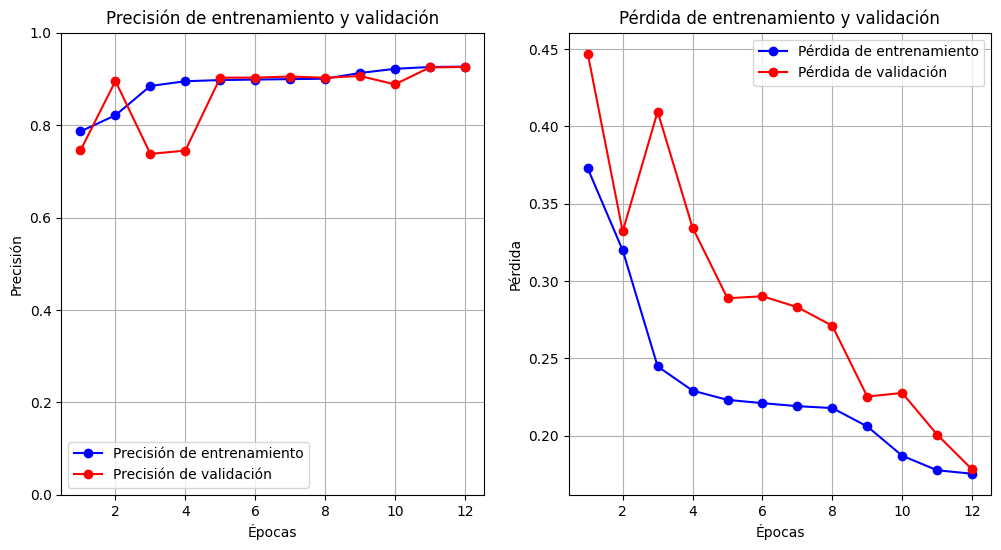

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
-> Evaluación de CNN_Optimized finalizada.
-> Entrenando modelo: LSTM_Optimized...
Epoch 1/12
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 216s 42ms/step - accuracy: 0.9733 - loss: 0.0633 - val_accuracy: 0.9991 - val_loss: 0.0044
Epoch 2/12
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 233s 47ms/step - accuracy: 0.9872 - loss: 0.0315 - val_accuracy: 0.9994 - val_loss: 0.0019
Epoch 3/12
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 226s 45ms/step - accuracy: 0.9843 - loss: 0.0356 - val_accuracy: 0.9998 - val_loss: 5.8328e-04
Epoch 4/12
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 223s 45ms/step - accuracy: 0.9920 - loss: 0.0198 - val_accuracy: 0.9999 - val_loss: 6.3274e-04
Epoch 5/12
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 225s 45ms/step - accuracy: 0.9931 - loss: 0.0184 - val_accuracy: 1.0000 - val_loss: 1.5314e-04
Epoch 6/12
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 238s 48ms/step - accuracy: 0.9932 - loss: 0.0180 - val_accuracy: 0.9999 - val_loss: 3.3346e-04
Epoch 7/12
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 214s 43ms/step - a

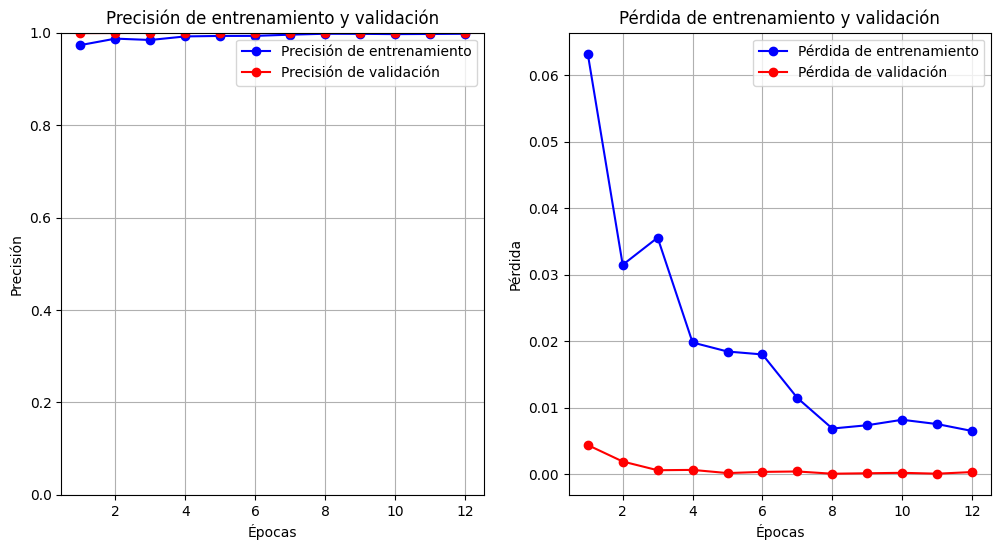

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step
-> Evaluación de LSTM_Optimized finalizada.
-> Entrenando modelo: Transfer_Learning_CNN...
Epoch 1/12
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 68s 13ms/step - accuracy: 0.9570 - loss: 0.0985 - val_accuracy: 0.9553 - val_loss: 0.1528
Epoch 2/12
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 61s 12ms/step - accuracy: 0.9921 - loss: 0.0259 - val_accuracy: 0.7051 - val_loss: 0.3962
Epoch 3/12
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 62s 12ms/step - accuracy: 0.9956 - loss: 0.0138 - val_accuracy: 0.9984 - val_loss: 0.0320
Epoch 4/12
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 62s 12ms/step - accuracy: 0.9982 - loss: 0.0075 - val_accuracy: 0.9997 - val_loss: 0.0018
Epoch 5/12
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 63s 13ms/step - accuracy: 0.9955 - loss: 0.0149 - val_accuracy: 0.9984 - val_loss: 0.0206
[Ingenieria del Modelo] Evaluación del modelo de Keras/TensorFlow
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9561 - loss: 0.1502
Accuracy: 95.61%
Loss: 0.1502
[Ingeniería del Modelo] Evaluac

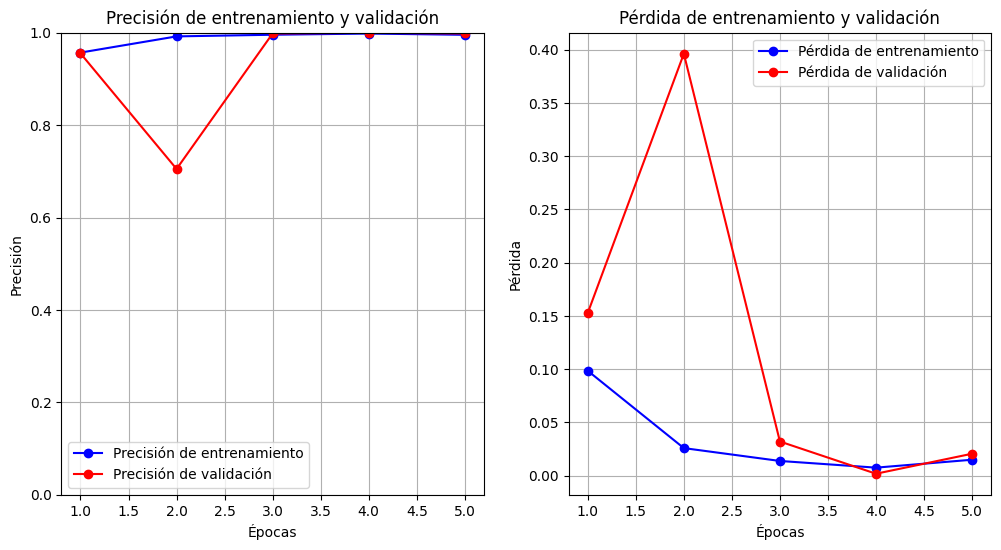

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step


2025-08-11 20:51:14,907 - absl - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


-> Evaluación de Transfer_Learning_CNN finalizada.

RESUMEN DE RENDIMIENTO DE LOS CLASIFICADORES DE DEEP LEARNING
|                       |   Accuracy |   Precision |   Recall |   F1-Score |
|:----------------------|-----------:|------------:|---------:|-----------:|
| CNN_Optimized         |      92.25 |       93.18 |    92.25 |      92.42 |
| LSTM_Optimized        |      99.99 |       99.99 |    99.99 |      99.99 |
| Transfer_Learning_CNN |      95.62 |       95.69 |    95.62 |      95.64 |
El mejor modelo es 'LSTM_Optimized' con un F1-Score de 99.99%
  ✓ Modelo de Keras exportado: models/lstm_optimized_training_exp_attack_tcp.csv.h5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step 


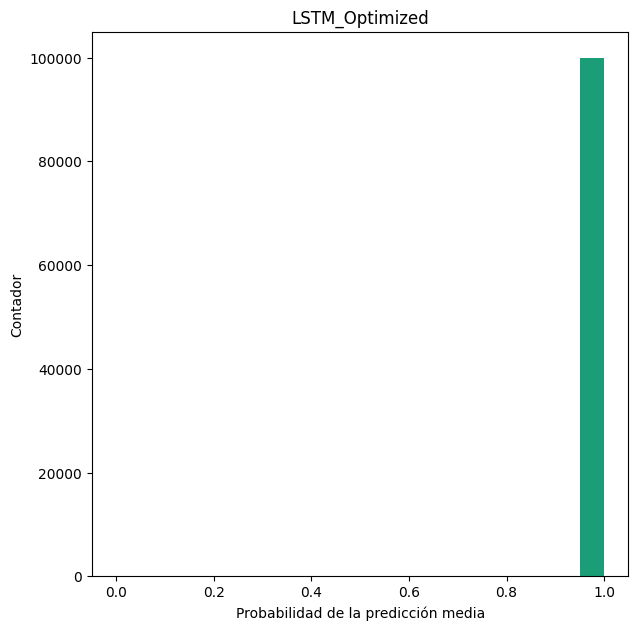


FASE II.- [Ingeniería del Modelo] DL - Fin


In [11]:
'''
PoC 2: Comparativa modelos predictivos basados en DL/ML
    DESCRIPCION: Entrena y evalúa una lista de clasificadores de Machine Learning,
    y presenta los resultados de los KPIs en una tabla clara.
'''
Flag_Balanced = True
def main():
    """
    Función principal que orquesta la ejecución del pipeline.
    """
    directory_path = 'C:/DataSets/asddos2024/Training/'
    attributes = PCA_25_Attributes

    if not os.path.isdir(directory_path):
        print(f"Error: El directorio '{directory_path}' no existe.")
        return

    print("=========================================================================")
    print("FASE II.- [Ingeniería del Modelo] DL - Inicio")
    print("=========================================================================")

    # Obtener la lista de archivos en el directorio
    files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]

    if not files:
        print(f"No se encontraron archivos CSV en el directorio: {directory_path}")
        return

    for file_name in files:
        input_file = os.path.join(directory_path, file_name)
        print(f"\n--- Procesando archivo: {file_name} ---")

        try:
            # 1. Carga inicial del dataset
            df = f_process_read_csv(input_file)
            if df is None:
                continue

            initial_rows, initial_cols = df.shape
            print(f"Filas iniciales: {initial_rows}, Columnas iniciales: {initial_cols}")

            #print("Exploracion del Conjunto de Datos sin Procesar: ")
            #for column, dtype in df.dtypes.items():
              #print(f"Columna: {column}, Tipo: {dtype}")

            # 2. Limpieza de datos
            df = f_cleaning(df)

            final_rows, final_cols = df.shape
            print(f"Filas Intermedias: {final_rows}, Columnas Intermedias: {final_cols}")

            # 3. Selección de atributos
            if not all(attr in df.columns for attr in attributes):
                missing_attrs = [attr for attr in attributes if attr not in df.columns]
                print(f"Advertencia: Faltan los siguientes atributos en el DataFrame: {missing_attrs}")
                df = df.loc[:, df.columns.intersection(attributes)]
            else:
                df = df[attributes]

            # 4. Preprocesamiento final
            df = f_preprocesado(df)
            final_rows, final_cols = df.shape

            final_rows, final_cols = df.shape
            print(f"Filas Procesadas: {final_rows}, Columnas Procesadas: {final_cols}")

            # 5. Generar y mostrar el informe de exploración
            report = [
                ["Métrica", "Valor"],
                ["Nombre del Archivo", file_name],
                ["Filas Iniciales", initial_rows],
                ["Columnas Iniciales", initial_cols],
                ["Filas Finales", final_rows],
                ["Columnas Finales", final_cols],
                ["Total de Filas Eliminadas", initial_rows - final_rows],
                ["Total de Columnas Eliminadas", initial_cols - final_cols]
            ]

            if Flag_Balanced == True:
                ratios_deseados = {'BENIGN': 0.7, 'DDoS': 0.3}
                df = f_balancear_dataset_oversampling(df=df[PCA_25_Attributes], 
                                                      ratios=ratios_deseados, target_samples=500000)
            
            final_rows, final_cols = df.shape
            print(f"Filas Finales: {final_rows}, Columnas Finales: {final_cols}")


            print("\n--- Informe de Exploración ---")
            print(tabulate(report, headers="firstrow", tablefmt="fancy_grid"))
            
            print(f"\n--- Desarrollo del Modelo DL: {file_name} ---")
            benchmarking_deep_learning(df, file_name)
            
        except Exception as e:
            print(f"Error inesperado al procesar '{file_name}': {e}")

    print("\n=========================================================================")
    print("FASE II.- [Ingeniería del Modelo] DL - Fin")
    print("=========================================================================")

    
    

if __name__ == "__main__":
    main()


## [F] V&V - Validacion y Verificación

En esta sección se implementará el código, mediante las funciones necesarias, que permitan mediante la utilización de un Conjunto de Datos con datos reales de producción, identificar de forma y manera univoca posibles ataques sobre la infraestructura de red

In [15]:
!dir models

 El volumen de la unidad C no tiene etiqueta.
 El n£mero de serie del volumen es: 34FA-F652

 Directorio de C:\Users\Usuario\OneDrive - Universidad de Alcala\Estudios Doctorado 1er A¤o\Cuadernos\CICDDoS\models

09/08/2025  10:15    <DIR>          .
11/08/2025  20:52    <DIR>          ..
01/08/2025  20:37            66.316 ada_boost_training_exp_attack_tcp.joblib
01/08/2025  20:37          (56.428) ada_boost_training_exp_attack_tcp.pkl
11/08/2025  20:51         1.560.080 lstm_optimized_training_exp_attack_tcp.csv.h5
07/08/2025  16:40            73.884 modelo_predictivo.pkl
09/08/2025  10:15           739.289 random_forests_training_exp_attack_tcp.joblib
09/08/2025  10:15           731.108 random_forests_training_exp_attack_tcp.pkl
01/08/2025  20:48       (1.533.049) random_forests_training_exp_attack_udp.joblib
01/08/2025  20:48       (1.524.852) random_forests_training_exp_attack_udp.pkl
               8 archivos      6.285.006 bytes
               2 dirs  353.030.344.704 bytes libres


In [16]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder
from typing import List, Dict
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os


def _preprocess_production_data(file_path: str, attributes: List[str]) -> pd.DataFrame:
    """
    Pre-procesa un archivo CSV de producción para su validación.
    """
    print(f"  -> Leyendo el conjunto de datos de producción desde: {file_path}")
    try:
        production_data = pd.read_csv(file_path)
    except FileNotFoundError:
        raise FileNotFoundError(f"El archivo no se encuentra en la ruta: {file_path}")

    production_data.columns = production_data.columns.str.strip()
    print("  -> Limpiando y preparando los datos de producción.")

    # 1. Asegurar que las columnas del modelo existen en el DataFrame
    required_cols = attributes + ['Label']
    if not all(col in production_data.columns for col in required_cols):
        missing_cols = [col for col in required_cols if col not in production_data.columns]
        raise ValueError(f"Columnas requeridas faltantes en el archivo de producción: {missing_cols}")
    else:
        print(" -> El conjunto de datos tiene las caracteristicas necesarias")
        
    # 2. Reemplazar valores infinitos y nulos para una limpieza robusta
    production_data.replace([np.inf, -np.inf], np.nan, inplace=True)
    production_data.dropna(inplace=True)

    # 3. Codificar automáticamente columnas no numéricas (si las hubiera)
    label_encoder = LabelEncoder()
    categorical_cols = production_data.select_dtypes(include=['object', 'category']).columns.drop('Label', errors='ignore')
    for col in categorical_cols:
        production_data[col] = label_encoder.fit_transform(production_data[col])

    # 4. Mapear las etiquetas para la clasificación binaria (0 = BENIGNO, 1 = ATAQUE)
    label_mapping = {'BENIGN': 0}
    # Mapear todas las demás etiquetas (ataques) a 1
    unique_labels = set(production_data['Label'].unique()) - set(label_mapping.keys())
    for label in unique_labels:
        label_mapping[label] = 1

    if 'Label' in production_data.columns:
        production_data['Label'] = production_data['Label'].map(label_mapping)
        production_data.dropna(subset=['Label'], inplace=True)

    print("  -> Preparación de datos de producción completada.")
    return production_data



# Suponiendo que la función _preprocess_production_data() ya está definida y funciona
# desde el código original.

def fase_produccion_keras(name_of_model: str, path_production_dataset: str, atributos: List[str]):
    """
    Valida el modelo de Keras entrenado con un conjunto de datos de producción
    y detecta si hay ataques.

    Args:
        name_of_model (str): La ruta del archivo H5 del modelo de Keras.
        path_production_dataset (str): La ruta del archivo CSV con datos de producción.
        atributos (List[str]): Lista de las características esperadas por el modelo.
    """
    try:
        print('\n--- 11. [FASE DE PRODUCCIÓN] - Análisis del tráfico en tiempo real ---')
        
        # 1. Pre-procesar los datos de producción
        production_data = _preprocess_production_data(path_production_dataset, atributos)
        
        # 2. Separar características y variable objetivo
        X_production = production_data[atributos]
        y_production = production_data['Label']
        
        # Asegurarse de que 'Label' no esté en las características
        if 'Label' in X_production.columns:
            X_production = X_production.drop('Label', axis=1)

        print("11.2- [Data Collection] Conversión de tipos y limpieza completada.")

        # 3. Cargar el modelo de Keras desde el archivo H5
        # ❌ ERROR EN LA FUNCIÓN ORIGINAL: Usa pickle.load()
        # ✅ SOLUCIÓN: Usa tf.keras.models.load_model()
        best_model = tf.keras.models.load_model(name_of_model)
        
        print(f"✓ Modelo de Keras cargado: {name_of_model}")
        print(f"Atributos: {list(X_production.columns)}")
        print(f"Características deseadas: {atributos}")
        
        # 4. Realizar predicciones
        print('11.3.- [Producción] - Realizando predicciones sobre el conjunto de producción.')
        
        # ✅ SOLUCIÓN: La salida de Keras predict() es un array de probabilidades, no una clase
        probabilities = best_model.predict(X_production)
        produccion_predicciones = np.argmax(probabilities, axis=1) # Convierte probabilidades a clases (0 o 1)

        # 5. Mostrar el resultado de la detección
        num_ataques_detectados = np.sum(produccion_predicciones == 1)
        if num_ataques_detectados > 0:
            print(f"\n🚨 ¡ALERTA! Se han detectado {num_ataques_detectados} instancias de ataques en el tráfico de red.")
            print("----------------------------------------------------------------------")
        else:
            print("\n✅ No se han detectado patrones de Ataque DDoS por Inundación TCP en el tráfico analizado")
            print("----------------------------------------------------------------------")

        # 6. Calcular métricas de rendimiento
        print('\n11.4.- [Producción] - Calculando métricas de rendimiento')
        accuracy_production = accuracy_score(y_production, produccion_predicciones)
        precision_production = precision_score(y_production, produccion_predicciones, average='weighted', zero_division=0)
        recall_production = recall_score(y_production, produccion_predicciones, average='weighted', zero_division=0)
        f1_production = f1_score(y_production, produccion_predicciones, average='weighted', zero_division=0)

        print("11.5.- [Producción] Métricas de rendimiento del modelo:")
        print(f"Accuracy: {accuracy_production * 100:.2f}%")
        print(f"Precision: {precision_production * 100:.2f}%")
        print(f"Recall: {recall_production * 100:.2f}%")
        print(f"F1-Score: {f1_production * 100:.2f}%")
        
    except FileNotFoundError as e:
        print(f"❌ Error de archivo: No se encontró el modelo o el dataset: {e}")
    except ValueError as e:
        print(f"❌ Error de datos: {e}")
    except Exception as e:
        print(f"❌ Error inesperado durante la fase de producción: {e}")


In [17]:
'''
PoC 2: Verificación y Validacion del Modelo con Datos de Producción Reales
    DESCRIPCION: Evalua las prestaciones de un modelo concreto con datos reales.
'''
# ----------------- VARIABLES GLOBALES CONFIGURABLES -----------------
# Atributos (columnas) que tu modelo espera para hacer predicciones.
# Es crucial que esta lista coincida con las características usadas en el entrenamiento.
def main():
    _atributos = PCA_25_Attributes
    _path_production_dataset: str = "C:/Datasets/Produccion/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"
    _model_path: str = './models/lstm_optimized_training_exp_attack_tcp.csv.h5'
    fase_produccion_keras(_model_path, _path_production_dataset, _atributos)

if __name__ == '__main__':
    main()  


--- 11. [FASE DE PRODUCCIÓN] - Análisis del tráfico en tiempo real ---
  -> Leyendo el conjunto de datos de producción desde: C:/Datasets/Produccion/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
  -> Limpiando y preparando los datos de producción.
 -> El conjunto de datos tiene las caracteristicas necesarias


2025-08-11 20:53:31,900 - absl - WARNING - Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


  -> Preparación de datos de producción completada.
11.2- [Data Collection] Conversión de tipos y limpieza completada.
✓ Modelo de Keras cargado: ./models/lstm_optimized_training_exp_attack_tcp.csv.h5
Atributos: ['Fwd IAT Std', 'Fwd IAT Mean', 'Fwd IAT Total', 'Flow IAT Min', 'Flow IAT Max', 'Flow IAT Std', 'Flow IAT Mean', 'Flow Packets/s', 'Flow Bytes/s', 'Bwd Packet Length Std', 'Bwd Packet Length Mean', 'Bwd Packet Length Min', 'Bwd Packet Length Max', 'Fwd Packet Length Std', 'Fwd Packet Length Mean', 'Fwd Packet Length Min', 'Fwd Packet Length Max', 'Total Length of Bwd Packets', 'Total Length of Fwd Packets', 'Total Backward Packets', 'Total Fwd Packets', 'Flow Duration', 'Protocol', 'Destination Port', 'Source Port']
Características deseadas: ['Fwd IAT Std', 'Fwd IAT Mean', 'Fwd IAT Total', 'Flow IAT Min', 'Flow IAT Max', 'Flow IAT Std', 'Flow IAT Mean', 'Flow Packets/s', 'Flow Bytes/s', 'Bwd Packet Length Std', 'Bwd Packet Length Mean', 'Bwd Packet Length Min', 'Bwd Packet Len

## Resultados

A partir de los resultados obtenidos, se puede concluir que tanto los algoritmos de Machine Learning (ML) como los de Deep Learning (DL) son eficaces para la detección de ataques de denegación de servicio distribuido (DDoS) a través del análisis de tramas de tráfico de red. Estos modelos demuestran una gran capacidad para identificar patrones anómalos, característicos de este tipo de ciberataques.



## Conclusiones 

En términos de rendimiento, se ha observado que tanto los modelos de Deep Learning (DL) como los de Machine Learning (ML) pueden ofrecer excelentes resultados. Sin embargo, existe una diferencia significativa en los requisitos de recursos computacionales. Los modelos de Deep Learning demandan una mayor cantidad de recursos, especialmente durante la fase de entrenamiento, lo que puede ser una limitación en entornos con recursos restringidos en los que se requiera implementar una solución basada en Aprendizaje Continuo. Por el contrario, algoritmos de Machine Learning como Random Forest han demostrado ser una alternativa muy eficiente, ofreciendo un gran rendimiento con una menor carga computacional.

La elección entre un enfoque de ML o DL debe basarse en los objetivos específicos del proyecto y los recursos disponibles. Si bien los modelos de Deep Learning pueden capturar patrones más complejos, los algoritmos de Machine Learning pueden ser una solución más práctica y robusta para la implementación de sistemas de detección de intrusiones (IDS) eficientes. La decisión final recae en el desarrollador, quien debe ponderar la precisión del modelo frente a la eficiencia en el consumo de recursos.

Adicionalmente, se ha demostrado que el uso de técnicas de balanceo de datos es crucial para lograr una mejor convergencia en los algoritmos predictivos. Cuando se trabaja con datasets desequilibrados, como el de ataques DDoS, donde la clase minoritaria (ataques) está subrepresentada, los modelos pueden sesgarse y volverse extremadamente buenos para predecir la clase mayoritaria (tráfico normal) a costa de fallar en la detección de ataques. El balanceo de datos, ya sea mediante técnicas de sobremuestreo (como SMOTE) o submuestreo, obliga al modelo a prestar la misma atención a ambas clases durante el entrenamiento. Esto permite que el algoritmo no solo aprenda los patrones de la clase mayoritaria, sino que también capture las características distintivas de la clase minoritaria, lo que se traduce en una convergencia más estable y un mejor rendimiento en métricas clave como el Recall y el F1-Score. Un modelo bien balanceado tendrá una mayor capacidad para detectar ataques reales, que es el objetivo principal de este tipo de sistemas.

Para futuros trabajos, se recomienda explorar la optimización de los modelos de Deep Learning para reducir su coste computacional, o bien investigar la combinación de ambos enfoques para crear sistemas híbridos que aprovechen las fortalezas de cada uno.